<a href="https://colab.research.google.com/github/jfonsecav/physics-tools/blob/main/CarrotNeuronalNetworks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/carrot2.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

<ipython-input-32-a1369739b7ce>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/carrot2.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])


,unidades
fecha,
2021-01-01,1354.0
2021-02-01,1354.0
2021-03-01,1354.0
2021-04-01,1438.0
2021-05-01,1438.0


In [ ]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2021-01-01,1354.0,4,1
2021-02-01,1354.0,0,2
2021-03-01,1354.0,0,3
2021-04-01,1438.0,3,4
2021-05-01,1438.0,5,5


In [ ]:
df.describe()

,unidades,weekday,month
count,1063.000000,1063.000000,1063.000000
mean,1943.991063,2.998119,6.424271
std,478.970690,2.002822,3.399575
min,1000.000000,0.000000,1.000000
25%,1635.250000,1.000000,3.000000
50%,1924.000000,3.000000,6.000000
75%,2208.000000,5.000000,9.000000
max,4042.000000,6.000000,12.000000


Preprocesado de los datos

In [ ]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

<ipython-input-36-71d13f3e1492>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['weekday'].loc[contador]=df['weekday'][i+8]
<ipython-input-36-71d13f3e1492>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['month'].loc[contador]=df['month'][i+8]


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.767258,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,2.0,9.0
1,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,4.0,10.0
2,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,0.0,11.0
3,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065,2.0,12.0
4,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065,-0.773833,2.0,1.0


In [ ]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

<ipython-input-37-133661a0e4e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reordenado.dropna(inplace=True)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,2.0,9.0,-0.767258,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397
1,4.0,10.0,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065
2,0.0,11.0,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065
3,2.0,12.0,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065
4,2.0,1.0,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065,-0.773833
...,...,...,...,...,...,...,...,...,...,...
1050,5.0,11.0,-0.634451,-0.625904,-0.604208,-0.582512,-0.643656,-0.643656,-0.725838,-0.753452
1051,6.0,11.0,-0.625904,-0.604208,-0.582512,-0.643656,-0.643656,-0.725838,-0.753452,-0.808021
1052,0.0,11.0,-0.604208,-0.582512,-0.643656,-0.643656,-0.725838,-0.753452,-0.808021,-0.756739
1053,1.0,11.0,-0.582512,-0.643656,-0.643656,-0.725838,-0.753452,-0.808021,-0.756739,-0.705457


In [ ]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
Ntotal = len(df)
Ntest = int(Ntotal*0.2)
print(Ntotal)
print(Ntest)

valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

1063
212
(595, 9) (595,) (30, 9) (30,)


Creamos el Modelo de Red Neuronal
Utilizaremos una Red Feedforward con Embeddings
Tenemos como entradas 9 columnas (2 embeddings y 7 pasos)

In [ ]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error',
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

Entrenamos nuestra máquina

In [ ]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dias (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 meses (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 2)                 16        ['dias[0][0]']                
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 4)                 52        ['meses[0][0]']               
                                                                                            

Visualizamos Resultados



1/1 [==============================] - 0s 100ms/step
30


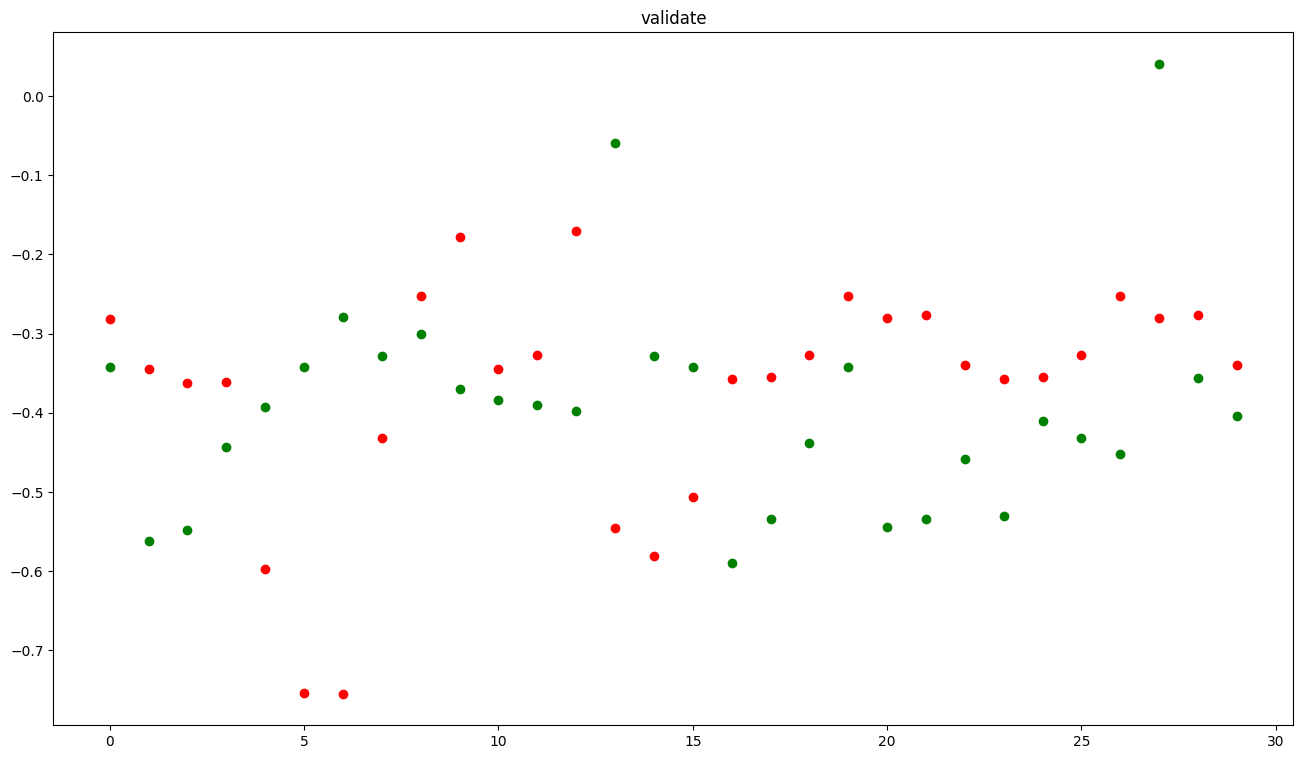

In [ ]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

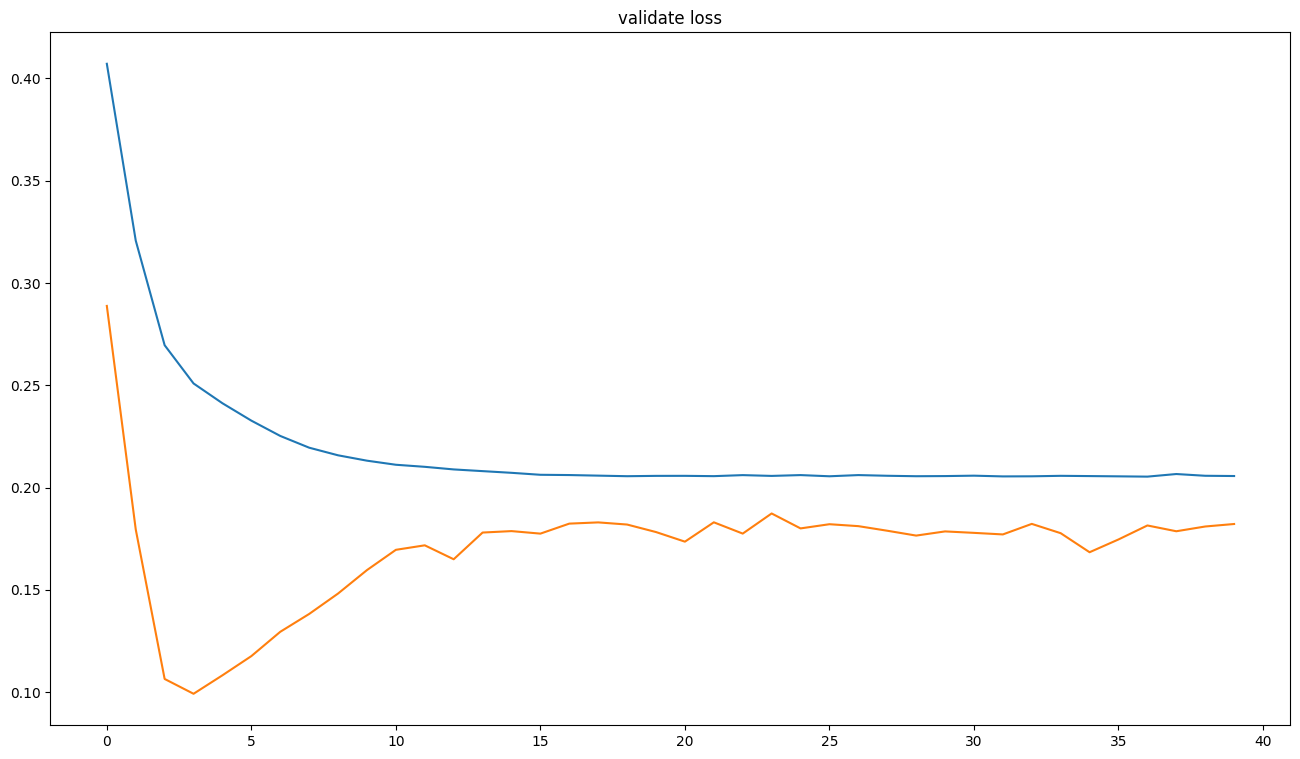

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,2000.000000,2091.897461,-91.897461
1,1667.000122,1996.673584,-329.673462
2,1688.000122,1969.562500,-281.562378
3,1847.000000,1972.502563,-125.502563
4,1923.000000,1612.439697,310.560303
5,2000.000000,1373.640015,626.359985
6,2097.000000,1372.870605,724.129395
7,2021.000000,1863.780151,157.219849
8,2063.000000,2136.456787,-73.456787
9,1958.000122,2250.739746,-292.739624


In [ ]:
compara2.describe()


,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,1922.866699,1954.615723,-31.749044
std,205.271683,221.417526,334.916626
min,1624.999878,1372.870605,-399.805176
25%,1825.500122,1970.297516,-279.406036
50%,1920.000000,2000.969910,-123.731140
75%,2000.000000,2093.805176,103.246490
max,2583.000000,2262.276123,740.635864


<Axes: >

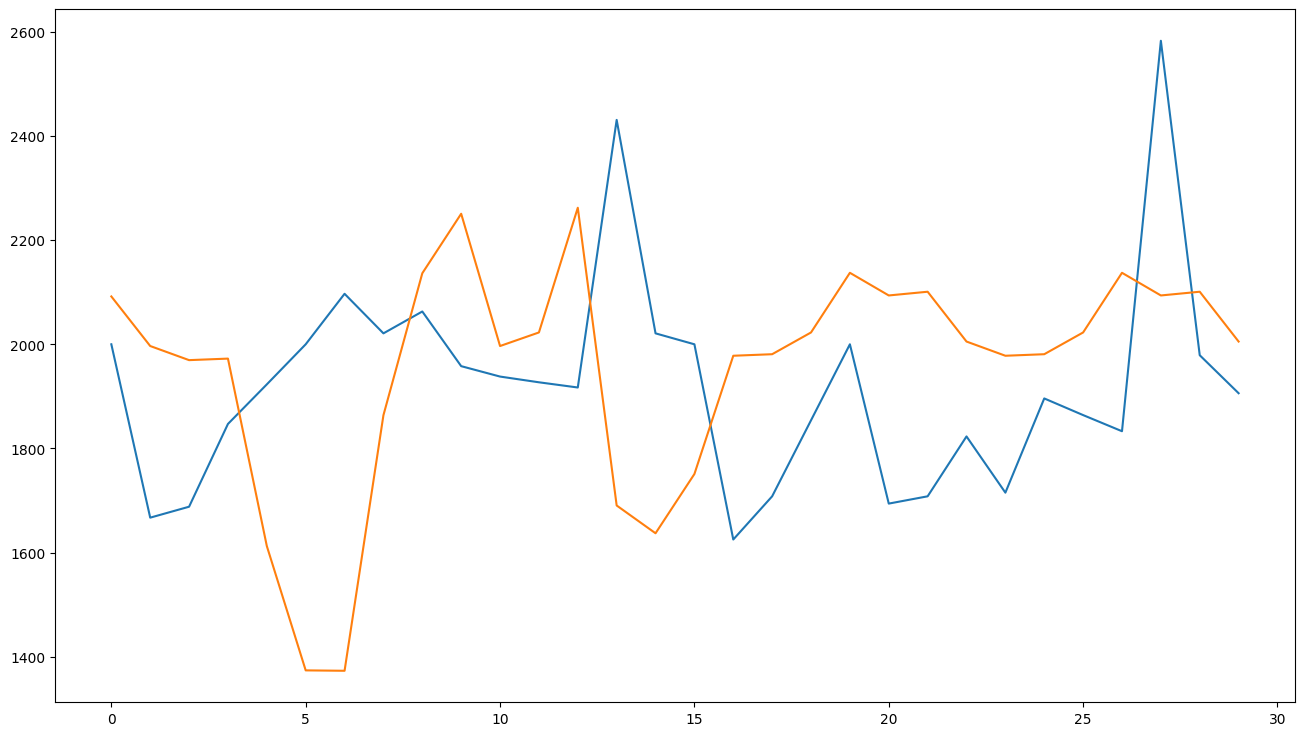

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()


Pronóstico
A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [ ]:
ultimosDias = df['2023-04-16':'2023-04-30']
dias = len(ultimosDias)
print(dias)
ultimosDias

15


,unidades,weekday,month
fecha,,,
2023-04-16,2469.0,6,4
2023-04-17,2625.0,0,4
2023-04-18,2708.0,1,4
2023-04-19,2729.0,2,4
2023-04-20,2521.0,3,4
2023-04-21,2542.0,4,4
2023-04-22,2458.0,5,4
2023-04-23,2614.0,6,4
2023-04-24,2771.0,0,4


In [ ]:
# load dataset
values = ultimosDias['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

<ipython-input-51-b9dc203d04fa>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
<ipython-input-51-b9dc203d04fa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['month'].loc[contador]=ultimosDias['month'][i+8]
<ipython-input-51-b9dc203d04fa>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reordenado.dropna(inplace=True)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,0.0,4.0,-0.737373,0.050506,0.469697,0.575758,-0.474747,-0.368687,-0.792929
1,1.0,4.0,0.050506,0.469697,0.575758,-0.474747,-0.368687,-0.792929,-0.005050
2,2.0,4.0,0.469697,0.575758,-0.474747,-0.368687,-0.792929,-0.005050,0.787879
3,3.0,4.0,0.575758,-0.474747,-0.368687,-0.792929,-0.005050,0.787879,1.000000
4,4.0,4.0,-0.474747,-0.368687,-0.792929,-0.005050,0.787879,1.000000,-0.262626
5,5.0,4.0,-0.368687,-0.792929,-0.005050,0.787879,1.000000,-0.262626,-1.000000
6,6.0,4.0,-0.792929,-0.005050,0.787879,1.000000,-0.262626,-1.000000,-0.161615


In [ ]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(2, 1, 9)
[[[ 5.00000000e+00  4.00000000e+00 -3.68686676e-01 -7.92928696e-01
   -5.04970551e-03  7.87878990e-01  1.00000000e+00 -2.62625694e-01
   -1.00000000e+00]]

 [[ 6.00000000e+00  4.00000000e+00 -7.92928696e-01 -5.04970551e-03
    7.87878990e-01  1.00000000e+00 -2.62625694e-01 -1.00000000e+00
   -1.61615372e-01]]]


6.0

In [ ]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

Pronóstico para la "próxima semana"

In [ ]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial= model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)


InvalidArgumentError: ignored